In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

from sklearn.cluster import KMeans

import os
import warnings
warnings.filterwarnings('ignore')

import multiprocessing

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HYS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HYS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HYS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
## 1. 트윗 전처리

file_dir = './data'
df = pd.DataFrame()

# 디렉토리에서 트윗 파일 불러오기
for file_name in os.listdir(file_dir):
    # 트윗 파일이 아니면 넘김
    #if ('PLTR' not in file_name) and ('palantir' not in file_name):
    if 'stock' in file_name:
        print(f"FIle skipped (not tweet): {file_name}")
        continue

    file_path = os.path.join(file_dir, file_name)
    
    # 트윗 파일 로드 및 병합
    try:
        file = pd.read_csv(file_path, index_col=0)
        if len(file) == 0:
            continue
        df = df.append(file)

    except Exception as error_message:
        print(f'error: {error_message}')
        
# 인덱스 초기화
df = df.reset_index(drop=True)
df = df.rename(columns={'text':'tweet'})
print(df)

      search_word                       user  \
0           Tesla              Spencer Yonce   
1           Tesla                   Ali Rana   
2           Tesla                       Rick   
3           Tesla                       Waed   
4           Tesla  Disgruntled Forza Painter   
...           ...                        ...   
94527       Tesla              Martin Burris   
94528       Tesla             UNICORN FOR PM   
94529       Tesla     Blocked by Sawyer Club   
94530       Tesla                    News 10   
94531       Tesla               Dan Burkland   

                                                   tweet  \
0                       Dads new car tesla model x\n1\n2   
1      What an amazing machine! resolution to GoGreen...   
2      Tesla appears to be suffering from to much #Ne...   
3      Shahed: what if tesla had a New Year sale and ...   
4      Tesla Model S Burns To A Crisp During Supercha...   
...                                                  ...   
945

In [3]:
# 중복 트윗 제거, 내용이 없는 트윗 제거
#print(df['tweet'].duplicated(keep='first').sum())
df = df.drop_duplicates(subset='tweet', keep='first')
df = df.dropna(subset=['tweet', 'likes'])
df

,search_word,user,tweet,date,comments,likes,retweets
4,Tesla,Disgruntled Forza Painter,Tesla Model S Burns To A Crisp During Supercha...,2016-01-01T16:21:27.000Z,NaN,1.0,NaN
18,Tesla,Warren Karlenzig,What's the business case for #sustainability? ...,2016-01-02T18:21:12.000Z,NaN,1.0,1.0
19,Tesla,skylin,"tesla doesn't talk all she replies with is """"\...",2016-01-02T20:25:54.000Z,1.0,1.0,2.0
29,Tesla,Nancy Mitchell,"#Tesla says it delivered 17,400 vehicles in th...",2016-01-03T17:41:56.000Z,NaN,1.0,3.0
30,Tesla,Daniel Arthur Smith,This is a dandy #SundayRead. Tesla stories sho...,2016-01-03T16:08:27.000Z,NaN,3.0,1.0
...,...,...,...,...,...,...,...
94504,Tesla,Jeremy Johnson,"Good morning \n@elonmusk\n, so a #TeslaFire ha...",2022-05-23T14:28:59.000Z,3.0,1.0,10
94507,Tesla,Gerald,Pandering to the crowd that isn't buying his p...,2022-05-23T12:47:09.000Z,1.0,4.0,31
94510,Tesla,brandon,i should have bought a tesla smh\n1\n2,2022-05-23T13:10:30.000Z,NaN,1.0,2
94516,Tesla,Goddess Sally,what wallet wants to help me fund the car paym...,2022-05-23T11:13:52.000Z,NaN,1.0,2


In [4]:
# nltk의 Lemmatizer(단어의 표제어 추출)와 stopwords(불용어 = 필요 없는 단어들)
lemma = WordNetLemmatizer()
stop_words = stopwords.words("english")

In [5]:
# 트윗을 정리하는 함수 정의
def clean_tweet(tweet):
    tweet = str(tweet)
    tweet = tweet.lower() # 소문자로 바꾸기
    tweet = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', tweet) # URL 제거
    tweet = re.sub('\$[a-zA-Z0-9]*', ' ', tweet) # ticker symbol($로 시작하는 주식 관련 심볼) 제거
    tweet = re.sub('\@[a-zA-Z0-9]*', ' ', tweet) # 유저 호출하는 기능(@로 시작) 제거
    tweet = re.sub('[^a-zA-Z\']', ' ', tweet) # 문자가 아닌 것 제거
    tweet = ' '.join( [w for w in tweet.split() if len(w)>1] )
    
    tweet = ' '.join([lemma.lemmatize(x) for x in nltk.wordpunct_tokenize(tweet) if x not in stop_words])
    tweet = [lemma.lemmatize(x, nltk.corpus.reader.wordnet.VERB) for x in nltk.wordpunct_tokenize(tweet) if x not in stop_words]
    return tweet 

In [6]:
# 트윗을 토큰화시킨 것, 그리고 토큰을 이어붙인 것을 새로운 열에 추가
df["clean_tweet"] = df["tweet"].apply(lambda x:clean_tweet(x))
df["cleaned_tweet"] = df["clean_tweet"].apply(lambda x:' '.join(x))

# 날짜를 DateTime으로 변환하고, 월/년도 열을 추가
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

df.tail()

,search_word,user,tweet,date,comments,likes,retweets,clean_tweet,cleaned_tweet,month,year
94504,Tesla,Jeremy Johnson,"Good morning \n@elonmusk\n, so a #TeslaFire ha...",2022-05-23 14:28:59+00:00,3.0,1.0,10,"[good, morning, teslafire, happen, yesterday, ...",good morning teslafire happen yesterday vancou...,5,2022
94507,Tesla,Gerald,Pandering to the crowd that isn't buying his p...,2022-05-23 12:47:09+00:00,1.0,4.0,31,"[pander, crowd, ', buy, product, alienate, cro...",pander crowd ' buy product alienate crowd buy ...,5,2022
94510,Tesla,brandon,i should have bought a tesla smh\n1\n2,2022-05-23 13:10:30+00:00,NaN,1.0,2,"[buy, tesla, smh]",buy tesla smh,5,2022
94516,Tesla,Goddess Sally,what wallet wants to help me fund the car paym...,2022-05-23 11:13:52+00:00,NaN,1.0,2,"[wallet, want, help, fund, car, payment, tesla...",wallet want help fund car payment tesla tesla ...,5,2022
94520,Tesla,Vote Blue - America Blue Biden 46th President,Tesla Driver Said He Broke a Window to Escape ...,2022-05-23 19:14:55+00:00,NaN,4.0,9,"[tesla, driver, say, break, window, escape, el...",tesla driver say break window escape electric ...,5,2022


In [7]:
# 정리된 트윗들
list(df['cleaned_tweet'][(df['year']==2022)&(df['month']==4)][:330])

['giddy cyberrodeo gigaaustin tesla',
 'finally take delivery yesterday beast refinement amaze plus compare year old feel want amd ryzonheated wiper steer season tire lith battery double panel thank',
 'lab tesla get full wrap ceramic window tint course ceramic coat surface interior exterior permanent solution sun damage ceramic coat everything also provide easy clean peace mind teslay',
 'hyundai fsd action ev tesla',
 'spring ski free way gigatexas starbase foot sea level need cyberrodeo tix please',
 'amaze tesla add new item march nd trev page break new product release tesla shop elon musk lavender soap',
 'need autopilot bark seat driver clearly indicate right turn ahead',
 'future potentially hard pill swallow tesla hw might show obsolete hw really could certain capability might work hw capability sell fsd package like say robotaxi',
 'video nikola tesla die new york city',
 "tesla transport model crossover giga berlin delivery electric elonmusk tesla savetheplanet gogreen video 

In [8]:
## 2. Label 찾기

# clean_tweet 열을 embedding이 지원하는 형식으로 변환
sent = [row for row in df["clean_tweet"]]

# Gensim의 Pharases 패키지를 이용하여 자동으로 common pharases (bigrams)을 찾기
phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]

sentences[4]

['dandy', 'sundayread', 'tesla', 'story', 'genre']

In [9]:
# Word2Vec 모델을 이용하여 Unsupervised Sentiment Analysis 수행
w2v_model = Word2Vec(min_count=4,
                     window=20,
                     vector_size=300,
                     #sample=1e-5,
                     alpha=0.03, 
                     min_alpha=0.0007,
                     negative=20,
                     seed=42,
                     workers=multiprocessing.cpu_count()-1)

# 위에서 찾은 common pharases를 이용하여 Word2Vec model의 vocab 만들기
w2v_model.build_vocab(sentences, progress_per=50000)

In [10]:
# Word2Vec training 시작
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1)

(9338205, 12838300)

In [55]:
# 말뭉치(corpus) 내에서 'data'라는 단어와 비슷한 단어 찾기 (코사인 유사도를 이용한 함수)
w2v_model.wv.most_similar(positive=['elon_musk'])

[('flight_attendant', 0.4498646557331085),
 ('misconduct_spacex', 0.409872829914093),
 ('freespeech', 0.4094915986061096),
 ('administration_democrat', 0.40928319096565247),
 ('social_governance', 0.3953218162059784),
 ('environmental_social', 0.3829660415649414),
 ('stock_suffer', 0.38144442439079285),
 ('call_esg', 0.3729376792907715),
 ('hypocrisy', 0.37008795142173767),
 ('blast_biden', 0.36787593364715576)]

In [12]:
# 모델 결과 저장
w2v_model.save("word2vec.model")

In [13]:
# K-means clustering을 위해 Word2Vec 모델의 결과(단어의 embedding)를 변수에 불러오기
word_vectors = Word2Vec.load("word2vec.model").wv

# 단어를 positive, negative, neutral 3가지로 군집화하기 위해 KMeans model에 embedding을 입력
model = KMeans(n_clusters=3, n_init=20, max_iter=1000, init='k-means++', random_state=42).fit(X=word_vectors.vectors.astype('double'))

In [57]:
# (테스트) 군집을 labelling하기 위해 각 군집에 무엇이 들어갔는지 확인하기
word_vectors.similar_by_vector(model.cluster_centers_[2], topn=200, restrict_vocab=None)

[("kate_'", 0.5328971147537231),
 ('askingforafriend', 0.5209748148918152),
 ('needa', 0.5196943879127502),
 ('kate_layne', 0.5128339529037476),
 ('drip', 0.5085388422012329),
 ('profile_money', 0.5075472593307495),
 ('daytrading_redpill', 0.4970264136791229),
 ('proceed_paypal', 0.4929181933403015),
 ('hey_alexa', 0.48722973465919495),
 ('stonks_trade', 0.4844081997871399),
 ('many_bitch', 0.4838884770870209),
 ('move_silence', 0.48333269357681274),
 ('rich_enough', 0.4750760495662689),
 ('wallstreetbets_barstoolsports', 0.4735325574874878),
 ('news_info', 0.47255825996398926),
 ('ion', 0.4721270501613617),
 ('stop_post', 0.4712458550930023),
 ('asf', 0.4580458104610443),
 ('someone_tell', 0.4550354480743408),
 ('feature_ad', 0.4542677104473114),
 ('tit', 0.45414483547210693),
 ('hoe', 0.4447173476219177),
 ('outta', 0.44382238388061523),
 ('welfare', 0.4401015043258667),
 ('new_note', 0.43917056918144226),
 ('crypto_trade', 0.4359423816204071),
 ('fool', 0.4330715835094452),
 ('dis',

In [35]:
# 군집을 labelling하기 (출력해서 확인해보고 직접 label을 설정해줘야 함)
negative_cluster_center = model.cluster_centers_[2]
positive_cluster_center = model.cluster_centers_[0]
neutral_cluster_center= model.cluster_centers_[1]

In [36]:
# 단어별로 embedding과 label을 기록하여 DataFrame을 만들기
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

# cluster_value 열을 추가하고 positive면 1, neutral이면 0, negative면 -1을 기록
words['cluster_value'] = [-1 if i==2 else 1 if i==0 else 0 for i in words.cluster]

# 군집으로부터 얼마나 근접해있는지 기록
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)

In [63]:
# (테스트) negative 단어들 출력
words[words["cluster_value"]==-1].sort_values("closeness_score")

,words,vectors,cluster,cluster_value,closeness_score,sentiments
50,still,"[-1.7655529, 0.41974437, 0.044937123, 0.932039...",2,-1,0.031892,negative
74,talk,"[0.16353635, 0.761414, -2.6411486, -1.0777056,...",2,-1,0.032493,negative
129,tweet,"[0.21146227, -3.0226076, -0.5123098, 1.3191888...",2,-1,0.033039,negative
57,give,"[-0.28384528, -2.4288528, -2.3982644, 3.372923...",2,-1,0.033257,negative
47,back,"[-2.3063037, 0.94242406, 0.2518781, 1.1676595,...",2,-1,0.033359,negative
...,...,...,...,...,...,...
6047,mile_teslatweets,"[0.05467891, -0.0037240838, 0.067879096, -0.00...",2,-1,0.279329,negative
6219,omfg,"[0.29981497, 0.08045581, -0.17551765, -0.12211...",2,-1,0.332974,negative
7418,needa,"[0.07553782, -0.11343475, -0.21063247, -0.3146...",2,-1,0.346568,negative
6834,move_silence,"[0.09566414, -0.00995692, -0.12285966, 0.04892...",2,-1,0.454144,negative


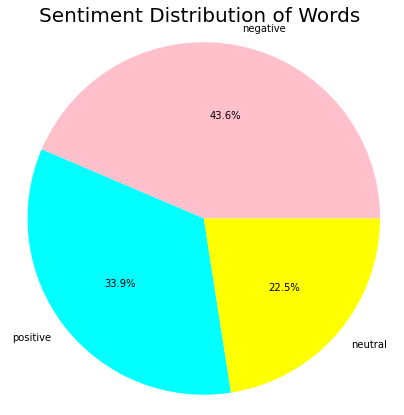

,index,sentiments
0,negative,3304
1,positive,2568
2,neutral,1708


In [39]:
# 단어의 Sentiment 분포를 Plot
emotion = {0: "neutral",
           1: "positive",
          -1: "negative"}

words["sentiments"] = words["cluster_value"].map(emotion)


fig = plt.gcf()
fig.set_size_inches(7, 7)
colors = ["pink","cyan","yellow"]
df_pie = words["sentiments"].value_counts().reset_index()
plt.pie(df_pie["sentiments"], labels=df_pie["index"], radius=2, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
plt.title("Sentiment Distribution of Words ", fontsize=20)
plt.show()
df_pie

In [40]:
# 단어의 sentiment를 기반으로 트윗 전체에 대한 sentiment를 구하는 함수 정의
def get_sentiments(df, sent_dict):
    total_sentiment = 0
    word_count = 0
    avg = 0
    words = df["clean_tweet"]
    for word in words:
        if sent_dict.get(word):
            total_sentiment += int(sent_dict.get(word))
        word_count += 1
    
    if word_count != 0:
        avg = total_sentiment / word_count
    
    # 평균값이 0.15 미만이면 negative, 0.15 초과면 positive, 그 외는 neutral (수치는 임의로 설정)
    sentiment = -1 if avg < -0.15 else 1 if avg > 0.15 else 0
    return sentiment

In [41]:
# {'단어':'cluster_value'} 형태의 dictionary 생성
words_dict = dict(zip(words.words, words.cluster_value))
# 행(트윗)마다 sentiment를 계산하고 새로운 열에 기록
df["sentiment"] = df.apply(get_sentiments, args=(words_dict,), axis=1)

In [42]:
# (테스트) sentiment 개수 확인 (1 = positive, 0 = neutral, -1 = negative)
df["sentiment"].value_counts()

-1    8339
 0    6015
 1    4706
Name: sentiment, dtype: int64

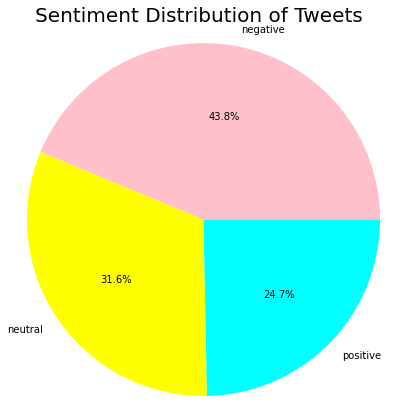

,index,sentiments_val
0,negative,8339
1,neutral,6015
2,positive,4706


In [44]:
# 트윗의 Sentiment 분포를 Plot
emotion = {0: "neutral",
           1: "positive",
          -1: "negative"}

df["sentiments_val"] = df["sentiment"].map(emotion)
df_pie = df["sentiments_val"].value_counts().reset_index()
fig = plt.gcf()
fig.set_size_inches(7, 7)
colors = ["pink","yellow","cyan"]
plt.pie(df_pie["sentiments_val"], labels=df_pie["index"], radius=2, autopct="%1.1f%%", colors=colors)
plt.axis('equal')
plt.title("Sentiment Distribution of Tweets ", fontsize=20)
plt.show()
df_pie

In [45]:
# (테스트) 2021년 10월의 negative 트윗들
df_negative = df[df["sentiment"]==-1]
list(df_negative['cleaned_tweet'][(df['year']==2021)&(df['month']==10)])

['arrest tesla',
 'ok ok already lathrop pronounce lay thrup gif alt',
 'narrative push many anti tesla conspiracy theorist msm writer side whole mar catalog wow really put tslaq tweet article straight face',
 'sell tesla model carmax give long range mile dent quarter panel use car market crazy right lol',
 'best car world',
 'interest feature apple best rat show never saw come give raucous relationship cook musk tesla',
 'ever see track tesla',
 'tesla brother',
 'know better would seem someone send cath copy financial shenanigan might even read gif alt cathie wood today announce third quarter sell vehicle globally year year yoy quarter quarter qoq meanwhile blame yoy decline u sale chip shortage ev require chip per car produce',
 'every third car la tesla',
 'glad fuddy duddy automaker start sell ev think far ahead tesla sell everything make every ev get head start',
 'somebody tesla see many tesla one batmobile vibe',
 'guerrilla market like ape market fellow bayc check yet miss baf

In [46]:
# (테스트) 2021년 10월의 positive 트윗들
df_positive = df[df["sentiment"]==1]
list(df_positive['cleaned_tweet'][(df['year']==2021)&(df['month']==10)])

['tesla modelsplaid full speed spring mountain speedyjeff careful brake may fail',
 'congrats tesla delivery',
 "color canyon still vibrant drive bigcottonwood friend photograph new red model day ' post tomorrow absolutely gorgeous chasingsunsets",
 'brand new supercharger open commute route tesla',
 "' wait watch episode",
 'even vacation reminder wonderful community',
 'hey find pretty cool park spot mar tesla',
 'truth plaid love wrap plaid',
 'let drive u home tonight',
 'beginner room electric mobility tesla hype tesla universe today oct pm cdt clubhouse com beginner room electric mobility tesla tesla universe wednesday october pm cest pierre zahlen kat paterno andreas ludt new curious battery electric vehicle tesla room ask question focus',
 'tesla increase model model price san francisco oct electric vehicle maker tesla implement price increase across entire model model lineup overnight update online configurator u auto business tech weeklyvoice com tesla increase model model pr

In [47]:
# (테스트) negative 트윗 몇개
list(df[df["sentiment"]==-1]["cleaned_tweet"][300:330])

['fact every hour tesla get another million mile worth data',
 "vote latter tesla thursdaythrill much via real really asleep hoax ' fake",
 "c ' mon ' buy say real hoax tesla selfdrivingcars",
 'maybe tesla funky bathroom right hb lgbt ncpol wearenotthis',
 "' pay kind publicity maybe someone via tesla",
 'yet another reason munter embarrass state tesla lose fight open second store north carolina',
 'take tesla floor contemplate entire life true mean',
 'find miss tesla lose last night contemplate wanna go go thru last night',
 'someone want buy tesla model would kind',
 'present future really work mine nikola tesla',
 'love murder tesla modelx',
 'gonna drive tesla wear checker fedora',
 'get tesla replace',
 'ford ceo mark field make level play field argument tesla allow sell direct sell thru dealer like ford',
 'never see many tesla motor wheninrome guess',
 'compete autonomouscars apple google tesla elonmusk',
 "norway ' target year away folk current trajectory bankrupt eternity te

In [48]:
# (테스트) positive 트윗 몇개
list(df[df["sentiment"]==1]["cleaned_tweet"][300:330])

['cartier come back stanford shop center across tesla',
 'happily charge two tesla wall connector near route giant despair hill climb since',
 'roadside tesla charge station roadtrip thefuture lowbattery',
 'th july special tesla stealth supertank ml flvr vape eliquid instagram com tulsa vapor store instagram photo',
 'uber driver cute drive tesla',
 'finally find tesla sign former burlington st kenilworth ramp hamont',
 'smartflower smartcar bright limitless future teslamodelx teslamodels teslamotors smartflowerpop',
 "' add great example new eve tesla channel eve",
 'tesla coil griffith park observatory overlook hollywood sign',
 "' amaze way tesla drive thankful",
 'nice shoot post today plugshare user edward london kentucky supercharger americanflag unify tesla ev',
 'inthedriverseat week visit life automotive discuss tesla sit noon sunday',
 'tesla electric festival tomorrow unveil tesla blvd parade noon hamont',
 'first ride new tesla teslap frunk bigballer los angeles california

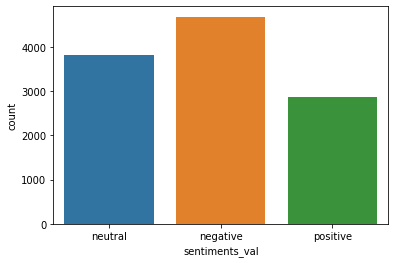

In [49]:
## 3. Data Visualization

data_list=[" ford"," bmw "," tesla "," audi "," bollingermotors "," hyundai "," dodge "]
pattern="|".join(data_list)
df_sent=df[(df["cleaned_tweet"].str.contains(pattern))]
sns.countplot(x=df_sent["sentiments_val"]);

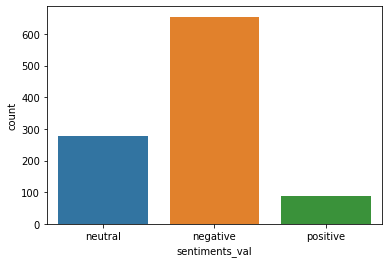

In [50]:
data_list=["costs","batteries"," climate "," fuel "," price "," tax ","afford","privilege","money"]
pattern="|".join(data_list)
df_sent=df[(df["cleaned_tweet"].str.contains(pattern))]
sns.countplot(x=df_sent["sentiments_val"]);

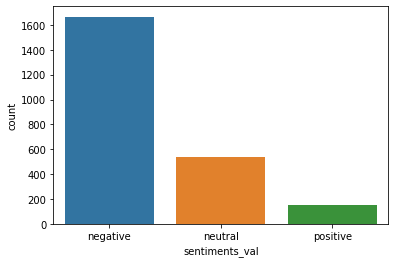

In [51]:
data_list=["buy", "stock", "sell", "TSLA"]
pattern="|".join(data_list)
df_sent=df[(df["cleaned_tweet"].str.contains(pattern))]

sns.countplot(x=df_sent["sentiments_val"]);

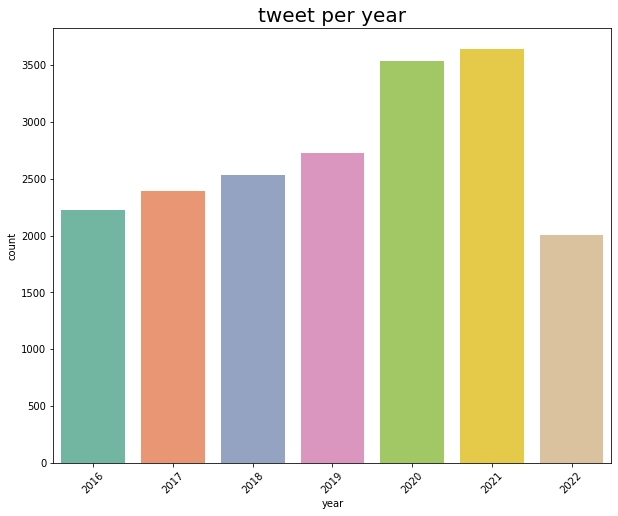

In [52]:
# 연도별 tweet 개수
plt.subplots(figsize = (10,8))
chart = sns.countplot(x="year",data=df, palette="Set2");
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title("tweet per year", fontsize=20)
plt.show()

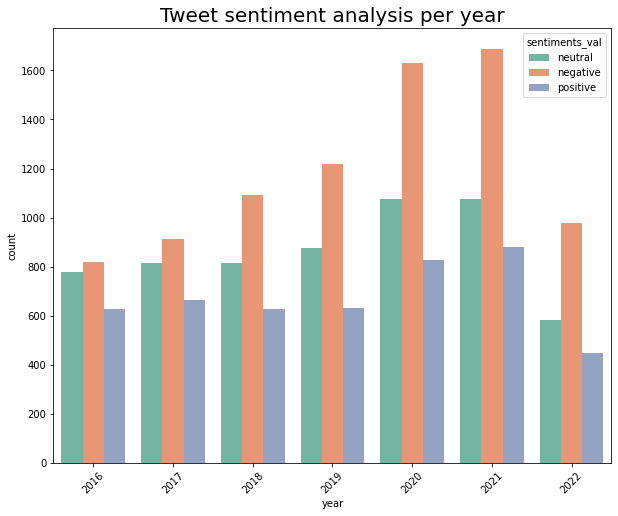

In [53]:
# 연도별 트윗의 감성분석 통계
plt.subplots(figsize = (10,8))
chart = sns.countplot(x="year",data=df, palette="Set2",hue="sentiments_val");
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title("Tweet sentiment analysis per year", fontsize=20)
plt.show()